In [1]:
import scipy
import numpy as np


def brightness(img):
    """
    Подсчет яркости изображения.
    Возращаемое значение -- матрица (yij), где yij - яркость пикселя img[i, j]
    """
    return (0.299 * img[:, :, 0] + 0.587 * img[:, :, 1] + 0.114 * img[:, :, 2]).astype(np.float64)


def energy_function(img):
    '''
    Функция считает энергию всех пикселей изображения img
    Возращаемое значение -- матрица (Eij), где Eij - энергия пикселя img[i, j]
    '''
    Y = brightness(img)
    ker_x = [[0., 0., 0.],
             [1., 0., -1.],
             [0., 0., 0.]]
    ker_y = [[0., 1., 0.],
             [0., 0., 0.],
             [0., -1., 0.]]
    I_x = scipy.signal.convolve2d(Y, ker_x, boundary='symm', mode='same')
    I_y = scipy.signal.convolve2d(Y, ker_y, boundary='symm', mode='same')
    return np.sqrt(I_x * I_x + I_y * I_y).astype(np.float64)


def change_energy(energy, mask):
    '''
    Изменение energy отдельных областей, обозначенных '1' в mask
    Возращает измененную матрицу energy
    '''
    delta = np.float64(energy.shape[0] * energy.shape[1] * 256.0)
    energy += delta * mask


def vertical_transition(dp, pos, s, prev, delta):
    '''
    Переход динамики для deleat_vertical shrink
    dp - матрица состояний
    pos - позиция пересчитываемого элемента
    s - смещене по горизонтали
    prev - матрица востоновления пути
    '''
    y, x = pos
    if x + s < 0 or x + s >= dp.shape[1]:
        return
    if dp[y - 1, x + s] + delta < dp[y, x]:
        dp[y, x] = dp[y - 1, x + s] + delta
        prev[y, x] = s


def find_vertical_seam(img, mask):
    '''
    Нахождение вертикального шва с минимальной энергией из img.
    Возвращает маску шва.
    '''
    dp = np.full((img.shape[0], img.shape[1]), np.inf, dtype='float64')
    prev = np.zeros((img.shape[0], img.shape[1]), dtype='int8')

    energy = energy_function(img)
    change_energy(energy, mask)

    dp[0, :] = energy[0, :]

    height, width = energy.shape
    for y in range(1, height):
        for x in range(0, width):
            vertical_transition(dp, (y, x), -1, prev, energy[y][x])
            vertical_transition(dp, (y, x), 0, prev, energy[y][x])
            vertical_transition(dp, (y, x), 1, prev, energy[y][x])

    cur_position = [height - 1, 0]
    lowest_energy = dp[height - 1, 0]
    for x in range(1, width):
        if lowest_energy > dp[height - 1, x]:
            cur_position[1] = x
            lowest_energy = dp[height - 1, x]

    seam_mask = np.zeros((height, width), dtype='int8')
    y, x = cur_position
    seam_mask[y, x] = 1
    while cur_position[0] > 0:
        cur_position[0] += -1
        cur_position[1] += prev[y, x]
        y, x = cur_position
        seam_mask[y, x] = 1
        
    return seam_mask


def horizontal_shrink(img, mask):
    '''
    Удаление вертикального шва с минимальной энергией из img.
    '''
    seam_mask = find_vertical_seam(img, mask)
    height, width, _ = img.shape

    new_mask = np.zeros((height, width - 1), dtype='int8')
    out = np.zeros(((height, width - 1, 3)), dtype='uint8')
    for i in range(0, height):
        k = 0
        for j in range(0, width - 1):
            if seam_mask[i][j]:
                k += 1
            out[i][j] = img[i][j + k]
            new_mask[i][j] = mask[i][j + k]

    return [out, new_mask, seam_mask]


def vertical_shrink(img, mask):
    '''
    Сжатие на 1 pxl по вертикали
    '''
    transp = (img[:, :, 0].transpose(),
              img[:, :, 1].transpose(), img[:, :, 2].transpose())
    mask = mask.transpose()

    out, new_mask, seam_mask = horizontal_shrink(np.stack(transp, axis=-1), mask)
    out_channels = (out[:, :, 0].transpose(),
                    out[:, :, 1].transpose(), out[:, :, 2].transpose())
    return [np.stack(out_channels, axis=-1), new_mask.transpose(), seam_mask.transpose()]


def horizontal_expand(img, mask):
    '''
    Расширить избражения по вертикали на 1pxl
    '''
    seam_mask = find_vertical_seam(img, mask)
    height, width, _ = img.shape
    new_mask = np.zeros((height, width + 1), dtype='int8')
    out = np.zeros((height, width + 1, 3), dtype='uint8')
    new_seam_mask = np.zeros((height, width + 1), dtype='int8')

    for i in range(0, height):
        k = 0
        for j in range(0, width):
            if seam_mask[i][j]:
                k = 1
                delta = img[i][j + 1] if j + 1 != width else img[i][j]
                out[i][j + k] = img[i][j] // 2 + delta // 2
                out[i][j] = img[i][j]
                new_mask[i][j + k] = 0
            else:
                out[i][j + k] = img[i][j]
                new_mask[i][j + k] = mask[i][j]

    return [out, new_mask, seam_mask]


def vertical_expand(img, mask):
    '''
    Расширить избражения по вертикали на 1 pxl
    '''
    transp = (img[:, :, 0].transpose(),
              img[:, :, 1].transpose(), img[:, :, 2].transpose())
    mask = mask.transpose()

    out, new_mask, seam_mask = horizontal_expand(np.stack(transp, axis=-1), mask)
    out_channels = (out[:, :, 0].transpose(),
                    out[:, :, 1].transpose(), out[:, :, 2].transpose())
    return [np.stack(out_channels, axis=-1), new_mask.transpose(), seam_mask.transpose()]


def seam_carve(img, op, mask=None):
    '''
    Изменяет img в 4-х режимах op используя mask
    '''
    if mask is None:
        mask = np.zeros(img.shape[:2], dtype='int8')

    do = {'horizontal shrink': horizontal_shrink,
          'vertical shrink': vertical_shrink,
          'horizontal expand': horizontal_expand,
          'vertical expand': vertical_expand}
    return do[op](img, mask)

In [2]:
def convert_img_to_mask(img):
        return ((img[:, :, 0] != 0) * -1 + (img[:, :, 1] != 0)).astype('int8')

def get_seam_coords(seam_mask):
    coords = np.where(seam_mask)
    t = [i for i in zip(coords[0], coords[1])]
    t.sort(key=lambda i: i[0])
    return tuple(t)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49


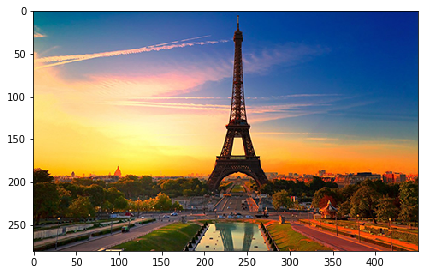

In [6]:
%matplotlib inline
from skimage.io import imread, imshow, imsave

out = imread('img-Copy1.png')
mask = imread('tests/01_test_img_input/mask.png')
m = convert_img_to_mask(mask)

for i in range(0, 50):
    print(i)
    out, m, seam = seam_carve(out, 'horizontal' + ' ' + 'shrink')
    
imshow(out)
imsave('out.png', out)